In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import math
import re
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140

In [2]:
OUT_DIR   = Path(r"C:\Users\bseis\ABthesis\data\analysis")
CORE_PATH = Path(r"C:\Users\bseis\ABthesis\data\processed\crsp_weekly_core.parquet")

ASOF  = "20241227"
K     = 6
MINOV = 156
NORM  = "sqrt"

def _find_one(glob_pat: str) -> Path:
    hits = sorted(glob.iglob(str(OUT_DIR / glob_pat)))
    if not hits:
        raise FileNotFoundError(f"No file matches pattern: {glob_pat}")
    return Path(hits[-1])

base = f"nmi_tier1_asof{ASOF}_k{K}_min{MINOV}_{NORM}"
path_mi  = _find_one(f"mi_bits_*{base}.parquet")
path_nmi = _find_one(f"nmi_*{base}.parquet")
path_H   = _find_one(f"entropy_bits_*{base}.parquet")

print("[Paths]\n", path_mi, "\n", path_nmi, "\n", path_H)

[Paths]
 C:\Users\bseis\ABthesis\data\analysis\mi_bits_nmi_tier1_asof20241227_k6_min156_sqrt.parquet 
 C:\Users\bseis\ABthesis\data\analysis\nmi_nmi_tier1_asof20241227_k6_min156_sqrt.parquet 
 C:\Users\bseis\ABthesis\data\analysis\entropy_bits_nmi_tier1_asof20241227_k6_min156_sqrt.parquet


In [3]:
panel = pd.read_parquet(CORE_PATH)
panel["date"] = pd.to_datetime(panel["date"])
panel["permno"] = pd.to_numeric(panel["permno"], errors="coerce").astype("Int64")

ASOF_DATE = panel["date"].max()
asof_info = (panel[panel["date"].eq(ASOF_DATE)]
             .sort_values(["permno","date"])
             .drop_duplicates("permno", keep="last")
             [["permno","ticker","comnam"]]
             .copy())

def _label_from_row(r):
    t = (str(r.get("ticker") or "")).strip().upper()
    n = (str(r.get("comnam") or "")).strip()
    if t and t != "NAN":
        return f"{t} — {n}" if n and n != "NAN" else t
    return n if n and n != "NAN" else f"PERMNO_{int(r['permno'])}"

asof_info["label"] = asof_info.apply(_label_from_row, axis=1)
PERMNO_TO_NAME = dict(zip(asof_info["permno"].astype(int), asof_info["label"]))
len(PERMNO_TO_NAME), list(PERMNO_TO_NAME.items())[:3]

(1367,
 [(10026, 'JJSF — J & J SNACK FOODS CORP'),
  (10032, 'PLXS — PLEXUS CORP'),
  (10104, 'ORCL — ORACLE CORP')])

In [4]:
# Load MI/NMI/H and rename indices to company names
R_mi  = pd.read_parquet(path_mi)
R_nmi = pd.read_parquet(path_nmi)
H     = pd.read_parquet(path_H)

# Normalize H to Series
if isinstance(H, pd.DataFrame):
    if H.shape[1] != 1:
        H = H.iloc[:, [0]]
    H = H.iloc[:, 0]
H.name = "entropy_bits"

# Helper: parse PERMNO from index label if it isn't a pure int (e.g., "AAPL_14593")
def _parse_permno(label) -> int | None:
    # try direct int
    try:
        return int(label)
    except Exception:
        pass
    # common patterns: "AAPL_14593", "AAPL — Apple Inc._14593"
    m = re.search(r"(\d{4,7})$", str(label))
    return int(m.group(1)) if m else None

# Build a mapping from current matrix labels to names
idx_labels = pd.Index(R_nmi.index)
label_to_name = {}

for lab in idx_labels:
    p = _parse_permno(lab)
    if p is not None and p in PERMNO_TO_NAME:
        label_to_name[lab] = PERMNO_TO_NAME[p]
    else:
        # fallbacks: try ticker/comnam already provided
        s = str(lab)
        label_to_name[lab] = s

# Apply mapping
R_mi_named  = R_mi.rename(index=label_to_name, columns=label_to_name)
R_nmi_named = R_nmi.rename(index=label_to_name, columns=label_to_name)
H_named     = H.copy()
H_named.index = H_named.index.map(lambda lab: label_to_name.get(lab, lab))

# Ensure synchronized order
R_mi_named  = R_mi_named.loc[R_mi_named.index, R_mi_named.index]
R_nmi_named = R_nmi_named.loc[R_nmi_named.index, R_nmi_named.index]

print("Shapes → MI:", R_mi_named.shape, "| NMI:", R_nmi_named.shape)
print("Index sample:", list(R_nmi_named.index[:5]))

Shapes → MI: (1000, 1000) | NMI: (1000, 1000)
Index sample: ['PLXS — PLEXUS CORP', 'ORCL — ORACLE CORP', 'MSFT — MICROSOFT CORP', 'TROW — T ROWE PRICE GROUP INC', 'HON — HONEYWELL INTERNATIONAL INC']


In [5]:
# QA: symmetry & diagonal
mi_asym  = float(np.nanmax(np.abs(R_mi_named.values  - R_mi_named.values.T)))
nmi_asym = float(np.nanmax(np.abs(R_nmi_named.values - R_nmi_named.values.T)))
print(f"Max asymmetry | MI: {mi_asym:.3e} | NMI: {nmi_asym:.3e}")

nmi_diag = np.diag(R_nmi_named.values)
print("NMI diag (min/median/max):",
      np.nanmin(nmi_diag), np.nanmedian(nmi_diag), np.nanmax(nmi_diag))

Max asymmetry | MI: 0.000e+00 | NMI: 0.000e+00
NMI diag (min/median/max): 1.0 1.0 1.0


In [6]:
# Helpers
def upper_tri(M: pd.DataFrame) -> np.ndarray:
    A = M.values
    iu = np.triu_indices_from(A, k=1)
    return A[iu]

def summarize_offdiag(M: pd.DataFrame, label=""):
    v = upper_tri(M)
    v = v[np.isfinite(v)]
    if len(v) == 0:
        print(f"[{label}] No finite off-diagonals.")
        return
    neg  = (v < 0).mean()*100
    zero = (v == 0).mean()*100
    print(f"[{label}] pairs={len(v):,} | neg={neg:.2f}% | zero={zero:.2f}% | "
          f"mean={np.nanmean(v):.6f} | med={np.nanmedian(v):.6f} | "
          f"p1={np.nanpercentile(v,1):.6f} | p5={np.nanpercentile(v,5):.6f} | "
          f"p95={np.nanpercentile(v,95):.6f} | p99={np.nanpercentile(v,99):.6f}")

In [7]:
# Global summaries
summarize_offdiag(R_mi_named,  "MI (bits)")
summarize_offdiag(R_nmi_named, "NMI")

[MI (bits)] pairs=476,776 | neg=5.51% | zero=0.00% | mean=0.144513 | med=0.127107 | p1=-0.055779 | p5=-0.003661 | p95=0.346341 | p99=0.504593
[NMI] pairs=476,776 | neg=5.51% | zero=0.00% | mean=0.045955 | med=0.040424 | p1=-0.017720 | p5=-0.001163 | p95=0.110128 | p99=0.160407


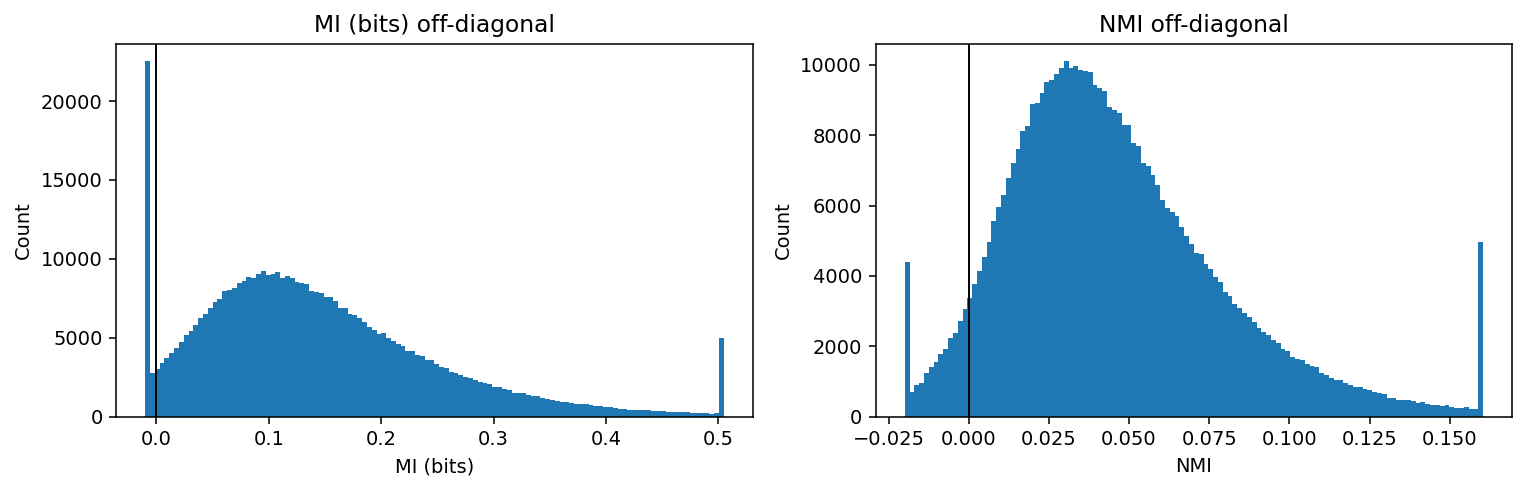

In [8]:
# Histograms
mi_vals  = upper_tri(R_mi_named);  mi_vals  = mi_vals[np.isfinite(mi_vals)]
nmi_vals = upper_tri(R_nmi_named); nmi_vals = nmi_vals[np.isfinite(nmi_vals)]

fig, axes = plt.subplots(1, 2, figsize=(11,3.6))

clip_hi_mi = np.nanpercentile(mi_vals, 99.0)
axes[0].hist(np.clip(mi_vals, -0.01, clip_hi_mi), bins=120)
axes[0].axvline(0, color="black", lw=1)
axes[0].set_title("MI (bits) off-diagonal"); axes[0].set_xlabel("MI (bits)"); axes[0].set_ylabel("Count")

clip_hi = np.nanpercentile(nmi_vals, 99.0)
axes[1].hist(np.clip(nmi_vals, -0.02, clip_hi), bins=120)
axes[1].axvline(0, color="black", lw=1)
axes[1].set_title("NMI off-diagonal"); axes[1].set_xlabel("NMI"); axes[1].set_ylabel("Count")

plt.tight_layout(); plt.show()

In [9]:
# Top & bottom NMI pairs (named)
A = R_nmi_named.values
names = R_nmi_named.index.to_list()
iu = np.triu_indices_from(A, k=1)

pairs = pd.DataFrame({
    "i": [names[i] for i in iu[0]],
    "j": [names[j] for j in iu[1]],
    "NMI": A[iu],
    "MI_bits": R_mi_named.values[iu],
}).dropna(subset=["NMI","MI_bits"])

TOP_K = 30
top_pairs = pairs.sort_values("NMI", ascending=False).head(TOP_K)
print("Top NMI pairs:"); display(top_pairs.reset_index(drop=True))

if (pairs["NMI"] < 0).any():
    worst = pairs.sort_values("NMI", ascending=True).head(min(TOP_K, (pairs["NMI"] < 0).sum()))
    print("Most negative NMI pairs:"); display(worst.reset_index(drop=True))
else:
    print("No negative NMI pairs.")

Top NMI pairs:


,i,j,NMI,MI_bits
0,CHTR — CHARTER COMMUNICATIONS INC NEW,LBRDK — LIBERTY BROADBAND CORP,0.743323,2.339854
1,CFG — CITIZENS FINANCIAL GROUP INC,KEY — KEYCORP NEW,0.543524,1.709565
2,CFG — CITIZENS FINANCIAL GROUP INC,RF — REGIONS FINANCIAL CORP NEW,0.539746,1.697681
3,CFG — CITIZENS FINANCIAL GROUP INC,FITB — FIFTH THIRD BANCORP,0.539602,1.697229
4,CFG — CITIZENS FINANCIAL GROUP INC,HBAN — HUNTINGTON BANCSHARES INC,0.538252,1.692984
5,CFG — CITIZENS FINANCIAL GROUP INC,CMA — COMERICA INC,0.492105,1.547837
6,MA — MASTERCARD INC,V — VISA INC,0.475194,1.494375
7,MUR — MURPHY OIL CORP,OVV — OVINTIV INC,0.472113,1.486240
8,CFG — CITIZENS FINANCIAL GROUP INC,PNC — P N C FINANCIAL SERVICES GRP INC,0.468839,1.474655
9,MET — METLIFE INC,PRU — PRUDENTIAL FINANCIAL INC,0.455327,1.430906


Most negative NMI pairs:


,i,j,NMI,MI_bits
0,INTA — INTAPP INC,HAS — HASBRO INC,-0.078736,-0.247916
1,LPLA — L P L FINANCIAL HOLDINGS INC,ACI — ALBERTSONS COMPANIES INC,-0.068500,-0.215828
2,ARMK — ARAMARK,NUVL — NUVALENT INC,-0.068378,-0.215543
3,PEP — PEPSICO INC,IONQ — IONQ INC,-0.064983,-0.204603
4,TOST — TOAST INC,K — KELLANOVA,-0.062765,-0.197629
5,CVS — C V S HEALTH CORP,COIN — COINBASE GLOBAL INC,-0.062633,-0.197209
6,GTLB — GITLAB INC,PEG — PUBLIC SERVICE ENTERPRISE GP INC,-0.061388,-0.193295
7,NUVL — NUVALENT INC,HAS — HASBRO INC,-0.060698,-0.191121
8,XOM — EXXON MOBIL CORP,HIMS — HIMS & HERS HEALTH INC,-0.059645,-0.187796
9,GIS — GENERAL MILLS INC,U — UNITY SOFTWARE INC,-0.059510,-0.187361


,i_name,j_name,NMI,MI_bits
0,CHTR — CHARTER COMMUNICATIONS INC NEW,LBRDK — LIBERTY BROADBAND CORP,0.743323,2.339854
1,CFG — CITIZENS FINANCIAL GROUP INC,KEY — KEYCORP NEW,0.543524,1.709565
2,CFG — CITIZENS FINANCIAL GROUP INC,RF — REGIONS FINANCIAL CORP NEW,0.539746,1.697681
3,CFG — CITIZENS FINANCIAL GROUP INC,FITB — FIFTH THIRD BANCORP,0.539602,1.697229
4,CFG — CITIZENS FINANCIAL GROUP INC,HBAN — HUNTINGTON BANCSHARES INC,0.538252,1.692984
5,CFG — CITIZENS FINANCIAL GROUP INC,CMA — COMERICA INC,0.492105,1.547837
6,MA — MASTERCARD INC,V — VISA INC,0.475194,1.494375
7,MUR — MURPHY OIL CORP,OVV — OVINTIV INC,0.472113,1.486240
8,CFG — CITIZENS FINANCIAL GROUP INC,PNC — P N C FINANCIAL SERVICES GRP INC,0.468839,1.474655
9,MET — METLIFE INC,PRU — PRUDENTIAL FINANCIAL INC,0.455327,1.430906


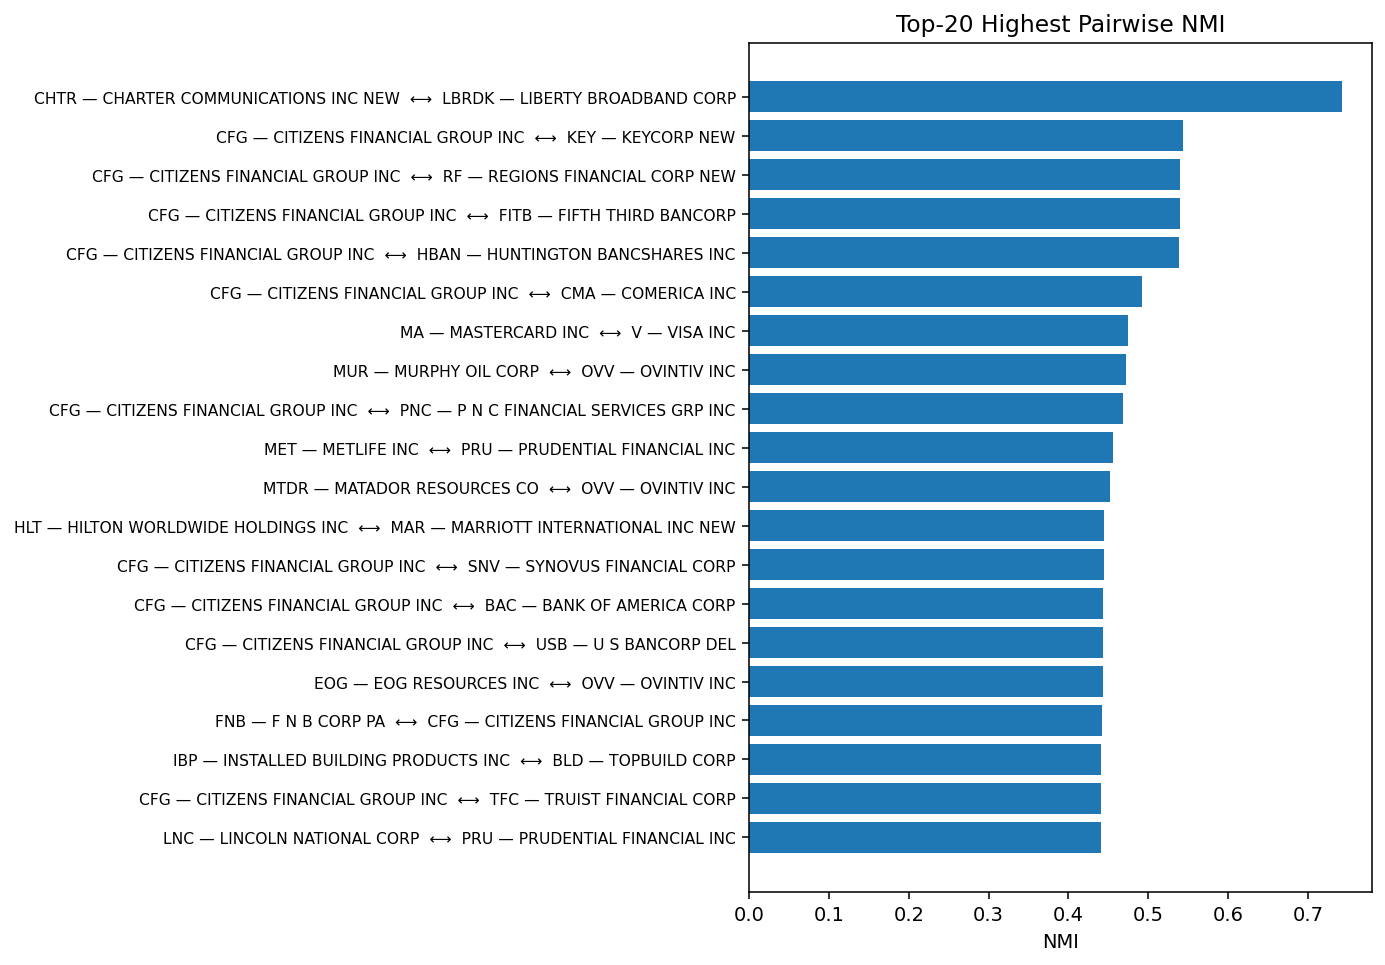

In [10]:
# Top-20 HIGHEST pairwise NMI across the whole matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

A_nmi = R_nmi_named.values
A_mi  = R_mi_named.values
names = R_nmi_named.index.to_list()

# Upper triangle indices (i < j) to avoid duplicates and diagonal
iu = np.triu_indices_from(A_nmi, k=1)

# Build an edge list
pairs_df = pd.DataFrame({
    "i_name": [names[i] for i in iu[0]],
    "j_name": [names[j] for j in iu[1]],
    "NMI":    A_nmi[iu],
    "MI_bits": A_mi[iu],
})

# Drop non-finite rows (NaN/inf)
pairs_df = pairs_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["NMI", "MI_bits"])

# Sort by NMI descending and take the top 20
TOPK = 20
top_pairs = pairs_df.sort_values("NMI", ascending=False).head(TOPK).reset_index(drop=True)

# Pretty display
pd.options.display.float_format = "{:.6f}".format
display(top_pairs)

# Bar chart of the top 20 pairs
labels = [f"{row.i_name}  ⟷  {row.j_name}" for row in top_pairs.itertuples(index=False)]
plt.figure(figsize=(10, 7))
plt.barh(range(TOPK), top_pairs["NMI"].values, color="tab:blue")
plt.yticks(range(TOPK), labels, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("NMI")
plt.title("Top-20 Highest Pairwise NMI")
plt.tight_layout()
plt.show()

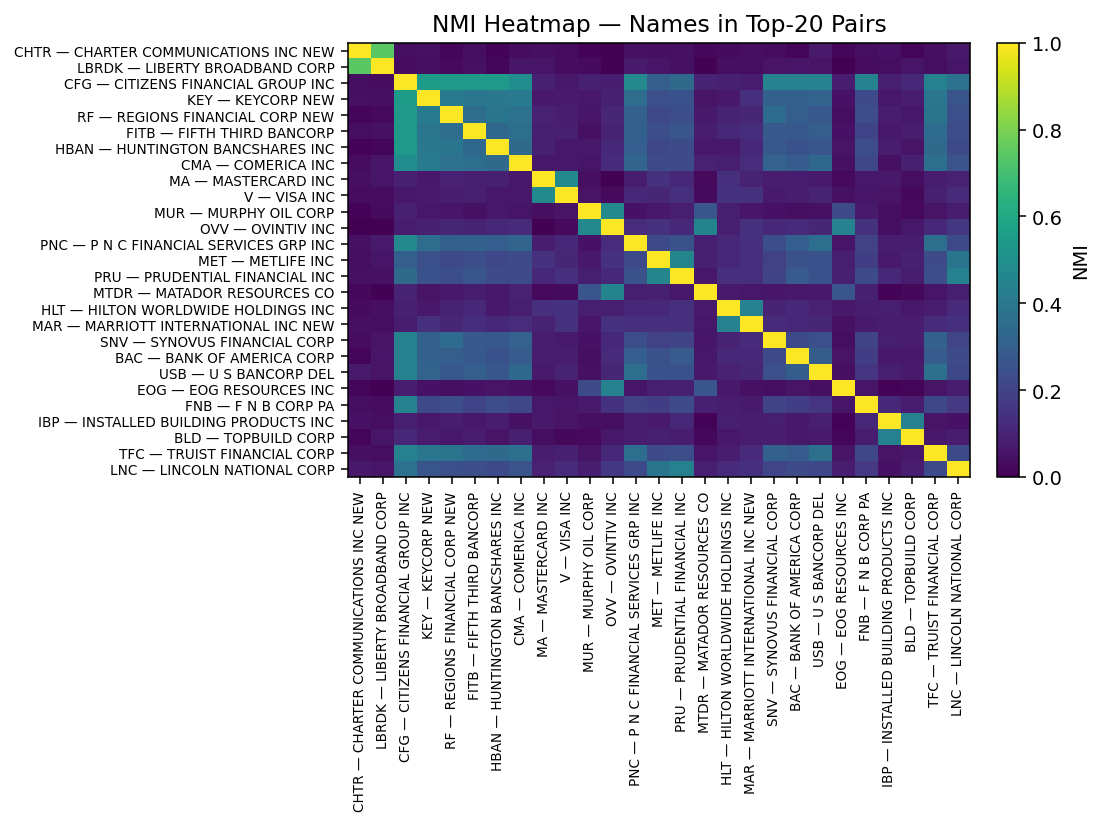

In [11]:
# Heatmap for the subgraph of those 20 pairs (unique names involved)
uniq = pd.Index(pd.unique(top_pairs[["i_name","j_name"]].values.ravel()))
Rn_sub = R_nmi_named.loc[uniq, uniq]

plt.figure(figsize=(8, 6))
im = plt.imshow(Rn_sub.values, interpolation="nearest", aspect="auto",
                vmin=0, vmax=np.nanpercentile(Rn_sub.values, 99))
plt.colorbar(im, fraction=0.046, pad=0.04, label="NMI")
plt.xticks(range(len(uniq)), uniq, rotation=90, fontsize=7)
plt.yticks(range(len(uniq)), uniq, fontsize=7)
plt.title("NMI Heatmap — Names in Top-20 Pairs")
plt.tight_layout(); plt.show()